### Sources  
* https://medium.com/@traffordDataLab/lets-make-a-map-in-r-7bd1d9366098  
* https://stackoverflow.com/questions/50859765/chloropleth-map-with-geojson-and-ggplot2  
* https://www.r-graph-gallery.com/327-chloropleth-map-from-geojson-with-ggplot2.html  

### SF issues  
* https://github.com/r-spatial/sf/issues/245
* copy/pasted gdal files from /home/anaconda3/pkgs/librgdal2-3-.../share/gdal to filepath at `Sys.getenv("GDAL_DATA")`
    * Did not override those already there...

In [2]:
if (!require(sf)) {
    install.packages("sf")
    library(sf)
}
library(ggplot2)
library(dplyr)
library(viridis)
library(tidyr)
library(gghighlight)
print('nice')

[1] "nice"


In [4]:
# Load map data
cp_map <- st_read("../data/central_park_geo.geojson", quiet = TRUE)

In [5]:
# Update values for different zones of CP West
cp_map$location <- as.character(cp_map$location)
cp_map$sitename <- as.character(cp_map$sitename)
cp_map$sitename[cp_map$location == 'CPW, W 97 St, West Drive, W 100 St'] <- 'Central Park West (Zone 1)'
cp_map$sitename[cp_map$location == 'CPW, 85 St Transverse, West Drive To 96 St'] <- 'Central Park West (Zone 2)'
cp_map$sitename[cp_map$location == 'West Drive, CPW, 65 St Transverse'] <- 'Central Park West (Zone 3)'
cp_map$sitename[cp_map$location == '66 St To 72 St, CPW To West Drive'] <- 'Central Park West (Zone 4)'

# Add numbers for each zone to display on map 
cp_map$number <- seq(1:63)

In [6]:
# Mark center of each park region 
centroids <- cp_map %>% 
    st_centroid() %>% 
    bind_cols(as_data_frame(st_coordinates(.))) 

Warning message in st_centroid.sf(.):
“st_centroid assumes attributes are constant over geometries of x”
Warning message in st_centroid.sfc(st_geometry(x), of_largest_polygon = of_largest_polygon):
“st_centroid does not give correct centroids for longitude/latitude data”
Warning message:
“`as_data_frame()` is deprecated, use `as_tibble()` (but mind the new semantics).
This warning is displayed once per session.”


In [9]:
# Read in squirrel data
squirrel_data <- read.csv('../data/squirrel_data.csv')

In [10]:
squirrel_data

X,sitename,Unique_Squirrel_ID,Climbing,Approaches,Vocalizations,Running_or_chasing,Eating_or_foraging,Count_diff..AM...PM.
<int>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,110th St & Lenox Ave Plgd,5,2,1,1,2,3,1
1,79th St Yard And Summit Rock,40,4,1,1,9,33,-6
2,"Belvdre. Cstl., Turtle Pond, Shkspr Grdn",44,10,0,3,23,31,0
3,Bendheim Plgd,2,0,0,0,1,2,0
4,Bernard Plgd,1,0,0,0,1,1,NA
5,Bethesda Terrace,142,42,7,1,37,119,-24
6,Blockhouse One,119,30,5,11,45,61,11
7,Cedar Hill,62,17,5,1,24,49,-12
8,Central Park South,108,18,4,1,30,84,12


In [11]:
#Join map boundaries to squirrel data
data_map <- left_join(cp_map, squirrel_data, by = 'sitename')

Warning message:
“Column `sitename` joining character vector and factor, coercing into character vector”


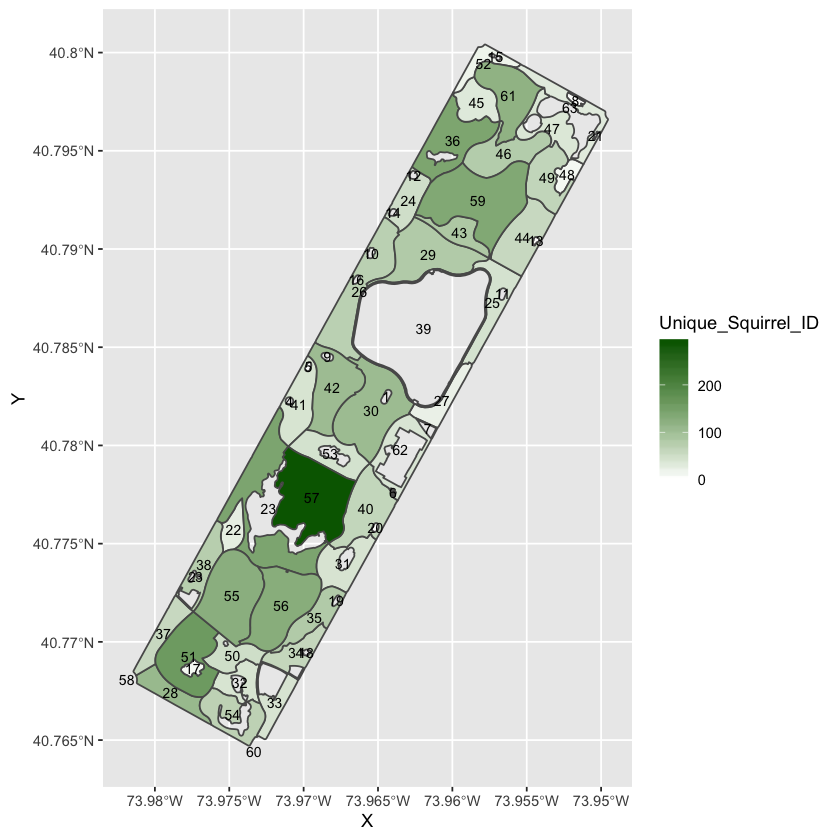

In [12]:
# Create choropleth (unhighlighted)
full_map <- ggplot(drop_na(data_map, Unique_Squirrel_ID)) + 
    geom_sf(aes(fill = Unique_Squirrel_ID)) + 
    geom_text(aes(X, Y, label = number), data = centroids, size = 3, color = 'black') +
    scale_fill_gradient(low = 'white', high = 'darkgreen', 
                        limits = c(0,max(squirrel_data$Unique_Squirrel_ID)))
full_map

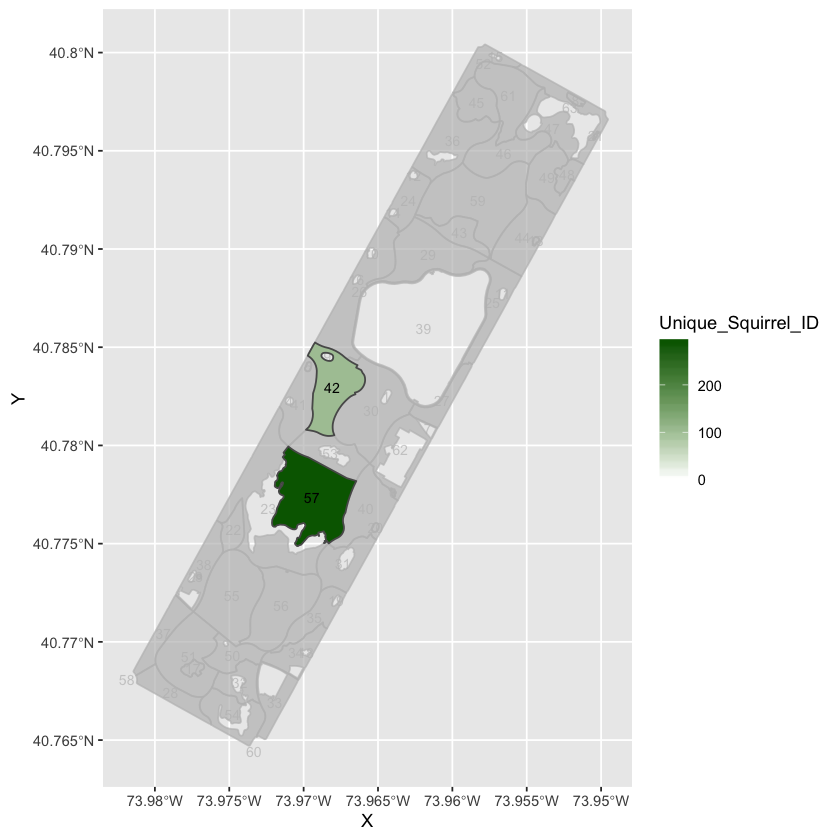

In [13]:
# Add highlight to map
full_map + 
    gghighlight(sitename %in% c('The Ramble', 'Ross Pinetum'), 
                label_key = Unique_Squirrel_ID)

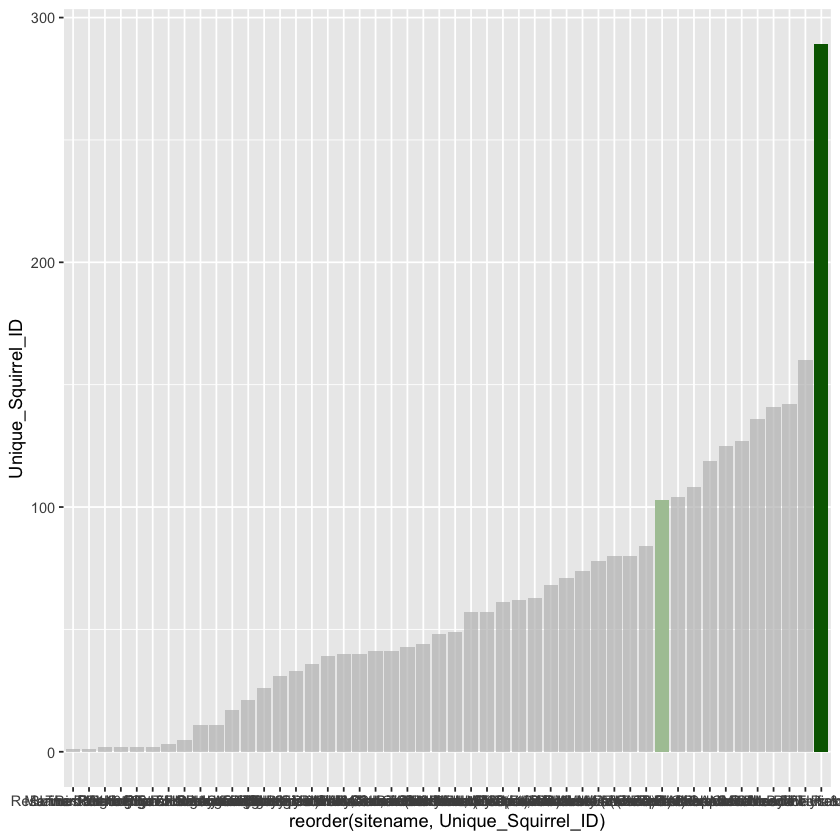

In [14]:
# Count of bar plot
ggplot(arrange(drop_na(data_map, Unique_Squirrel_ID), desc(Unique_Squirrel_ID))) + 
    geom_bar(aes(x = reorder(sitename, Unique_Squirrel_ID), 
                 y = Unique_Squirrel_ID, 
                 fill = Unique_Squirrel_ID), 
             stat = 'identity') + 
    scale_fill_gradient(low = 'white', 
                        high = 'darkgreen', 
                        limits = c(0,max(squirrel_data$Unique_Squirrel_ID))) +
    gghighlight(sitename %in% c('The Ramble', 'Ross Pinetum'), 
                label_key = Unique_Squirrel_ID)